# QM9 filter example

This notebook shows how to use an already trained generator and filter the results.

Since the number of unique physically meaningful structures is quite limited relaxing/analyzing "all" generated structures is wasteful. Here we present a way to find unique structures and filter out repeated ones, to enhance the versatility of the structures for more compute demanding analysis, e.g. relaxation with DFT.

Here we load an already trained model, if you are interested in how to train one, check the "QM9 training example" notebook.

In [19]:
from besselgan.utilities import create_generate_structures, create_generate_descriptor
from neuralil.bessel_descriptors import PowerSpectrumGenerator
from besselgan.models import GeneratorModel

import jax
import jax.numpy as jnp
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from ase import Atoms
from ase.visualize import view
import matplotlib.pyplot as plt

import pickle

First we create a descriptor generator, which will be used for the clustering inputs.  
The settings of this do not necessarily have to match with the one used for training.

In [20]:
R_CUT = 5
N_MAX = 4
N_NEIG = 10
N_TYPES = 3

descriptor_generator = PowerSpectrumGenerator(N_MAX, R_CUT, N_TYPES, N_NEIG)


@jax.jit
def generator_method(allpos, alltype, pos, types, cell):
    desc = descriptor_generator.process_some_data(allpos, alltype, pos, cell)
    desc = jnp.reshape(desc, (pos.shape[0], -1))
    desc = jnp.append(desc, jax.nn.one_hot(types, N_TYPES), axis=1)

    return desc

Load the precomputed data.

In [21]:
gen_snapshots = pickle.load(open("QM9_data/generator_weights.pck", "rb"))
anum_map, reverse_anum_map = pickle.load(open("QM9_data/anum_maps.pck", "rb"))

Reproduce the generator network used during the training.  
This MUST match exactly with the training model.

In [22]:
#Using a modelinfo datastructure would be more convenient
N_DIMENSIONS = 3
N_LATENT = 20
TYPES = np.array([6] * 5 + [1] * 12 + [8])
TYPES = np.array([anum_map[t] for t in TYPES])
N_POINTS = len(TYPES)
GENERATOR_SHAPE = [512, 256, 128, 64, 32]
GEN_CELL = jnp.array([[8.0, 0.0, 0.0], [0.0, 7.0, 0.0], [0.0, 0.0, 6.0]])

generator = GeneratorModel(
    features=GENERATOR_SHAPE,
    n_points=N_POINTS,
    n_dimensions=N_DIMENSIONS,
    n_latent=N_LATENT,
    n_scalars=0,
)


def postprocess(intermediate):
    pos = intermediate.reshape((N_POINTS, N_DIMENSIONS))
    pos = jnp.matmul(pos, GEN_CELL)
    return pos, TYPES, pos, TYPES, jnp.zeros(shape=(3, 3))

Utility function for structure and descriptor generation:

In [23]:
generate_structures = create_generate_structures(generator, postprocess, N_LATENT)
generate_single_desc = create_generate_descriptor(generator_method)

Generate 500 structures with the last values of the generator weights as ase.Atoms objects, and plot a very naive distance between the structures.

/home/pkovacs/miniconda3/envs/BesselGAN2/lib/python3.9/site-packages/flax/core/scope.py:600: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/home/pkovacs/miniconda3/envs/BesselGAN2/lib/python3.9/site-packages/flax/core/scope.py:601: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


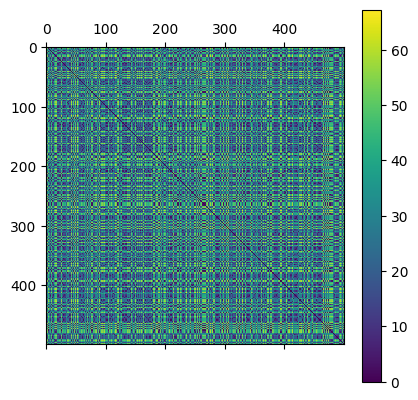

In [24]:
SEED = 4
rng = jax.random.PRNGKey(SEED)

rng, key = jax.random.split(rng)
all_pos, all_type, _, _, _ = generate_structures(gen_snapshots[-1], key, 500)
gen_atoms_list = []
for i in range(500):
    atom = Atoms(positions=all_pos[i])
    atom.set_atomic_numbers(
        np.array([reverse_anum_map[int(j)] for j in all_type[i]]).flatten()
    )
    atom.center(vacuum=3.0)
    gen_atoms_list.append(atom)


distances = np.sum(
    np.abs(all_pos[np.newaxis, :, :, :] - all_pos[:, np.newaxis, :, :]), axis=(-2, -1)
)
plt.matshow(distances)
plt.colorbar()

Generate permutation invariant molecular descriptors, by averaging the local descriptors of atoms with the same type. While it loses a lot of information, this is a straigtforward way to turn it permutation invariant.

In [25]:
gen_invariant_desc_list = []
for atoms in gen_atoms_list:
    tmp_type = np.array([anum_map[num] for num in atoms.get_atomic_numbers()])
    tmp_pos = atoms.positions
    tmp_pos = tmp_pos
    tmp_desc = generate_single_desc(tmp_pos, tmp_type, tmp_pos, tmp_type, atoms.cell[:])
    tmp_desc = np.array(tmp_desc.reshape((-1, tmp_desc.shape[-1])))

    invar_desc = np.zeros(shape=(0,))
    for i in range(N_TYPES):
        indices = np.where(TYPES == i)[0]
        invar_desc = np.append(invar_desc, np.mean(tmp_desc[indices, :], axis=0))

    gen_invariant_desc_list.append(invar_desc)

Use PCA for dimensionality reduction (both for visualization and to make the k-means more effective).  

Use k-means clustering on the reduced data to find groups of "similar" molecules, then pick the closest molecules to the centroids of the clusters as candidate structures.

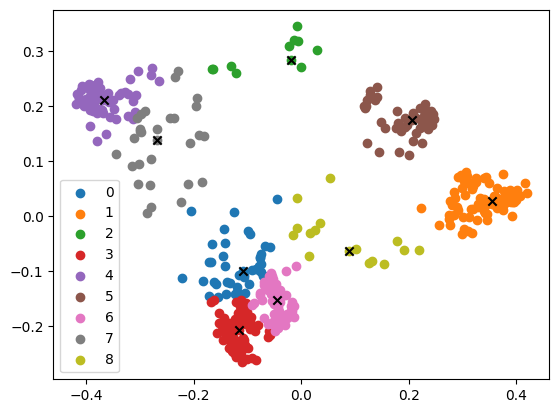

In [26]:
pca = PCA(n_components=2)
pca.fit(gen_invariant_desc_list)
transformed_pca = pca.transform(gen_invariant_desc_list)

N_cluster = 9
kmeans = KMeans(n_clusters=N_cluster, random_state=0, n_init="auto").fit(
    transformed_pca
)
for i in range(N_cluster):
    indices = np.where(np.array(kmeans.labels_) == i)[0]


picked = []
for i in range(N_cluster):
    center = kmeans.cluster_centers_[i]

    dists = np.sum((transformed_pca - center) ** 2, axis=1)
    ind = np.argmin(dists)
    picked.append(ind)
picked = np.array(picked)

for i in range(N_cluster):
    indices = np.where(np.array(kmeans.labels_) == i)[0]
    plt.scatter(transformed_pca[indices, 0], transformed_pca[indices, 1], label=str(i))

plt.scatter(
    transformed_pca[picked, 0], transformed_pca[picked, 1], marker="x", color="black"
)
plt.legend()

Visualize the 9 picked structures as a single Atoms object.

In [27]:
tmp_positions = np.zeros(0)
tmp_types = np.zeros(0)

for i, ind in enumerate(picked):
    tmp_positions = np.append(
        tmp_positions,
        gen_atoms_list[ind].positions
        + (i % 3) * np.array([10, 0, 0])
        + (i // 3) * np.array([0, 10, 0]),
    )
    tmp_types = np.append(tmp_types, gen_atoms_list[ind].get_atomic_numbers())

finalatoms = Atoms(positions=tmp_positions.reshape((-1, 3)), numbers=tmp_types)

view(finalatoms, viewer="x3d")